<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/FBProphet/TimeSeries_Forecasting_FBProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting With Prophet in Python**

Time series forecasting can be challenging as there are many different methods you could use and many different hyperparameters for each method.

## **Introduction**

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

In this tutorial, you will discover how to use the Facebook Prophet library for time series forecasting.

After completing this tutorial, you will know:

* Prophet is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.
* How to fit Prophet models and use them to make in-sample and out-of-sample forecasts.
* How to evaluate a Prophet model on a hold-out dataset.

## **Tutorial Overview**

This tutorial is divided into three parts; they are:

* 1. Prophet Forecasting Library
* 2. Car Sales Dataset
      * Load and Summarize Dataset
      * Load and Plot Dataset
* 3. Forecast Car Sales With Prophet
      * Fit Prophet Model
      * Make an In-Sample Forecast
      * Make an Out-of-Sample Forecast
      * Manually Evaluate Forecast Model

### **Prophet Forecasting Library**

[Prophet](https://github.com/facebook/prophet), or “*Facebook Prophet*,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an **additive time series forecasting** model, and the implementation supports trends, seasonality, and holidays.

> Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects
— Package ‘prophet’, 2019.

It is designed to be easy and completely automatic, e.g. point it at a time series and get a forecast. As such, it is intended for internal company use, such as forecasting sales, capacity, etc.

Install the Prophet library using Pip -> `!pip install fbprophet`

In [ ]:
!pip install pystan
!pip install fbprophet

Check whether fbprophet is installed or not and the version number with `!pip list`

In [ ]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl 

### **Car Sales Dataset**

We will use the monthly car sales dataset.

It is a s**tandard univariate time series** dataset that contains both a trend and seasonality. The dataset has 108 months of data and a naive persistence forecast can achieve a mean absolute error of about **3,235 sale**s, providing a lower error limit.

#### **Import Library**

We will import library that we need for this process

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fbprophet

#### **Load and Summarize Dataset**

First, let’s load and summarize the dataset.

Prophet requires data to be in Pandas DataFrames. Therefore, we will load and summarize the data using Pandas.

We can load the data directly from the URL by calling the `read_csv() Pandas function`, then summarize the shape (number of rows and columns) of the data and view the first few rows of data.

In [ ]:
# Load and Read Dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)
df.head(), df.tail()

(     Month  Sales
 0  1960-01   6550
 1  1960-02   8728
 2  1960-03  12026
 3  1960-04  14395
 4  1960-05  14587,        Month  Sales
 103  1968-08  16722
 104  1968-09  14385
 105  1968-10  21342
 106  1968-11  17180
 107  1968-12  14577)

In [ ]:
df.shape

(108, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


#### **Load and Plot Dataset**

A time-series dataset does not make sense to us until we plot it.

Plotting a time series helps us actually see if there is a trend, a seasonal cycle, outliers, and more. It gives us a feel for the data.

We can plot the data easily in Pandas by calling the `plot()` function on the DataFrame.

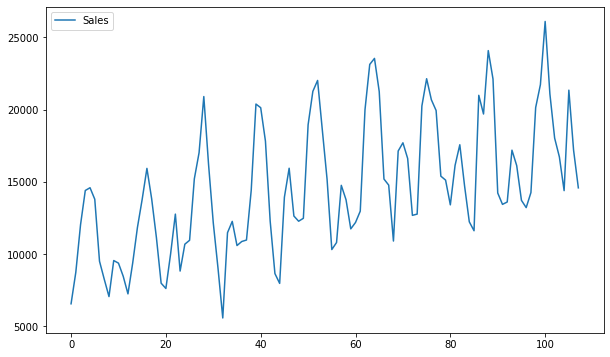

In [ ]:
# Lets plot dataset
df.plot(figsize=(10, 6))

**Check whether the dataset is Stationary or Not**


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf(x):
  res = adfuller(x)
  print("Test Statistic:", res[0])
  print('P-Value:', res[1])
  if res[1] < 0.05:
    print("Stationary")
  else:
    print("Non Stationary")

adf(df['Sales'])

Test Statistic: -1.2238127661752811
P-Value: 0.663269104983288
Non Stationary


### **Forecast Car Sales**

In this section, we will explore using the `Prophet` to forecast the car sales dataset.

Let’s start by fitting a model on the dataset

#### **Fit Prophet Model**

To use Prophet for forecasting, first, a `Prophet()` object is defined and configured, then it is fit on the dataset by calling the `fit()` function and passing the data.

The `Prophet()` object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.

The `fit()` function takes a *DataFrame* of time series data. The *DataFrame* must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name *‘y‘* and contain the observations.

This means we change the column names in the dataset. It also requires that the first column be converted to date-time objects, if they are not already (e.g. this can be down as part of loading the dataset with the right arguments to *read_csv*).

In [ ]:
# The input to Prophet is always a dataframe with two columns: ds and y.
# so lets change column name with ds for date and y for value/sales
from pandas import to_datetime
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

# Define the model
from fbprophet import Prophet
model = Prophet()

# Fit the model
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Running the example loads the dataset, prepares the DataFrame in the expected format, and fits a Prophet model.

By default, the library provides a lot of verbose output during the fit process. I think it’s a bad idea in general as it trains developers to ignore output.

Nevertheless, the output summarizes what happened during the model fitting process, specifically the optimization processes that ran.

#### **Make an In-Sample Forecast**

It can be useful to make a forecast on historical data.

That is, we can make a forecast on data used as input to train the model. Ideally, the model has seen the data before and would make a perfect prediction.

Nevertheless, this is not the case as the model tries to generalize across all cases in the data.

This is called making an in-sample (in training set sample) forecast and reviewing the results can give insight into how good the model is. That is, how well it learned the training data.

A forecast is made by calling the `predict()` function and passing a *DataFrame* that contains one column named *‘ds‘* and rows with date-times for all the intervals to be predicted.

There are many ways to create this `“forecast”` *DataFrame*. In this case, we will loop over one year of dates, e.g. the last 12 months in the dataset, and create a string for each month. We will then convert the list of dates into a *DataFrame* and convert the string values into date-time objects.

In [ ]:
# Get 12 last data
df.ds[-12:].values

array(['1968-01-01T00:00:00.000000000', '1968-02-01T00:00:00.000000000',
       '1968-03-01T00:00:00.000000000', '1968-04-01T00:00:00.000000000',
       '1968-05-01T00:00:00.000000000', '1968-06-01T00:00:00.000000000',
       '1968-07-01T00:00:00.000000000', '1968-08-01T00:00:00.000000000',
       '1968-09-01T00:00:00.000000000', '1968-10-01T00:00:00.000000000',
       '1968-11-01T00:00:00.000000000', '1968-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
# Define the periode which we want to predict
future = list()
for i in range(1, 13):
  date = '1968-%02d' % i
  future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])

In [ ]:
future

,ds
0,1968-01-01
1,1968-02-01
2,1968-03-01
3,1968-04-01
4,1968-05-01
5,1968-06-01
6,1968-07-01
7,1968-08-01
8,1968-09-01
9,1968-10-01


This *DataFrame* can then be provided to the `predict()` function to calculate a forecast.

The result of the `predict()` function is a DataFrame that contains many columns. Perhaps the most important columns are the forecast date time (*‘ds‘*), the forecasted value (`‘yhat‘`), and the lower and upper bounds on the predicted value (`‘yhat_lower‘` and `‘yhat_upper‘`) that provide uncertainty of the forecast.

          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14334.737769  12758.885882  15983.587365
1 1968-02-01  14905.955964  13214.692986  16406.853460
2 1968-03-01  20842.150502  19240.661942  22448.527619
3 1968-04-01  22870.095215  21288.995231  24465.113356
4 1968-05-01  24176.211162  22581.373874  25829.838649


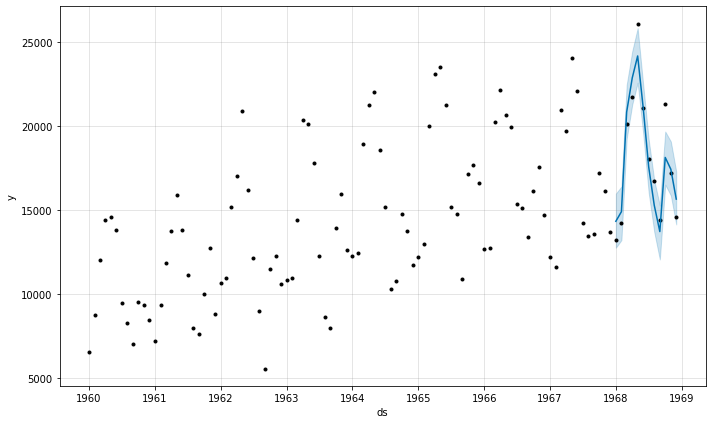

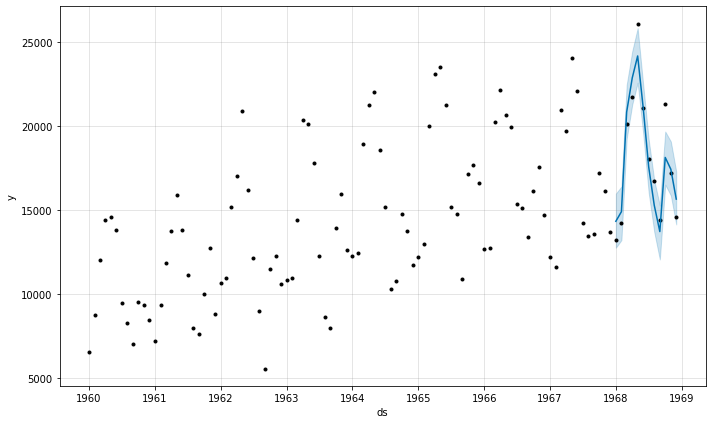

In [ ]:
# Use the model to make forecast
forecast = model.predict(future)

# Summarize forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot the forecast
model.plot(forecast)

Next, a plot is created. We can see the training data are represented as black dots and the forecast is a blue line with upper and lower bounds in a blue shaded area.

We can see that the forecasted 12 months is a good match for the real observations, especially when the bounds are taken into account.

#### **Make an Out-Sample Forecas**t

In practice, we really want a forecast model to make a prediction beyond the training data.

This is called an out-of-sample forecast.

We can achieve this in the same way as an in-sample forecast and simply specify a different forecast period.

In this case, a period beyond the end of the training dataset, starting 1969-01.

In [ ]:
# Lets call dataset first
df

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587
...,...,...
103,1968-08-01,16722
104,1968-09-01,14385
105,1968-10-01,21342
106,1968-11-01,17180


In [ ]:
# Define the periode which want to predictions
pred_month = list()
for i in range(1, 13): # We want to make prediction for 12 months
  date = '1969-%02d' % i
  pred_month.append([date])
pred_month = pd.DataFrame(pred_month)
pred_month.columns = ['ds']
pred_month['ds'] = to_datetime(pred_month['ds'])

In [ ]:
pred_month

,ds
0,1969-01-01
1,1969-02-01
2,1969-03-01
3,1969-04-01
4,1969-05-01
5,1969-06-01
6,1969-07-01
7,1969-08-01
8,1969-09-01
9,1969-10-01


          ds          yhat    yhat_lower    yhat_upper
0 1969-01-01  15375.960093  13939.769924  16943.526526
1 1969-02-01  16142.271673  14544.836941  17738.363677
2 1969-03-01  21351.832640  19819.729406  22868.122178
3 1969-04-01  23477.889811  21988.524379  25036.946840
4 1969-05-01  24988.440907  23300.617309  26665.950145


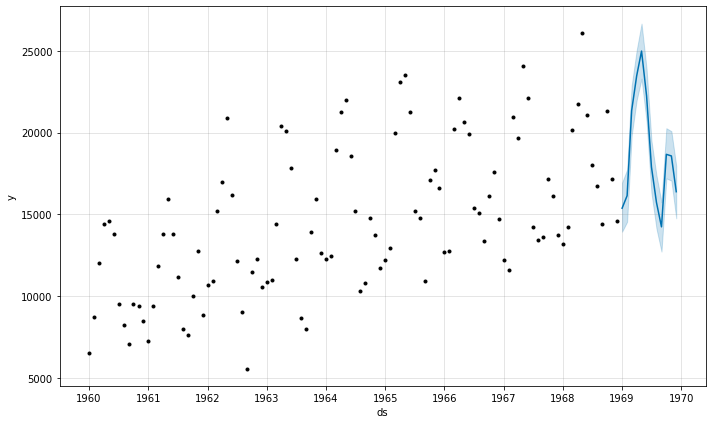

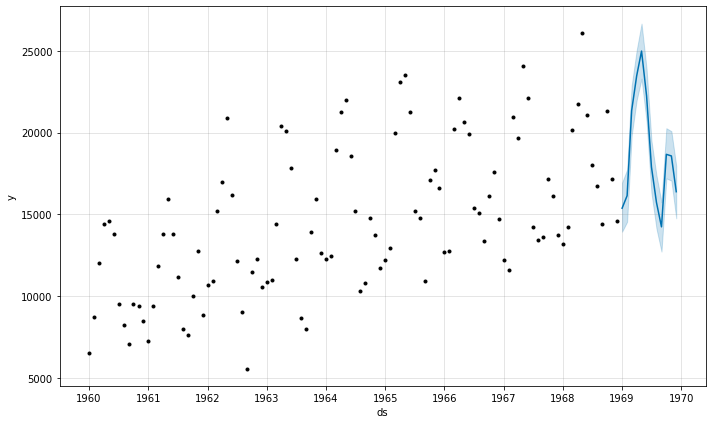

In [ ]:
# Use the model to make a forecast
forecast = model.predict(pred_month)

# Summarize forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Lets plot a forecast
model.plot(forecast)

#### **Manually Evaluate Forecast Model**

It is critical to develop an objective estimate of a forecast model’s performance.

This can be achieved by holding some data back from the model, such as the last 12 months. Then, fitting the model on the first portion of the data, using it to make predictions on the held-pack portion, and calculating an `error measure`, such as the mean absolute error across the forecasts. E.g. a simulated out-of-sample forecast.

The score gives an estimate of how well we might expect the model to perform on average when making an out-of-sample forecast.

We can do this with the samples data by creating a *new DataFrame* for training with the last 12 months removed.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Create test dataset, remove last 12 months
train = df.drop(df.index[-12:])
train.tail()

# Calculated MAE between expected and predicted
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values
print('Mean-Absolute-Error for Forecast Model:', mean_absolute_error(y_true, y_pred))

# # Plot Expected and Predicted values
# plt.plot(y_true, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()

Mean-Absolute-Error for Forecast Model: 1369.4853362518145


In [ ]:
y_true

array([13210, 14251, 20139, 21725, 26099, 21084, 18024, 16722, 14385,
       21342, 17180, 14577])

In [ ]:
y_pred

array([15375.96009323, 16142.27167281, 21351.83263979, 23477.88981138,
       24988.44090681, 22249.04115344, 17902.32992375, 15730.20180043,
       14235.95707016, 18671.78012704, 18573.50538638, 16386.03310619])

In [ ]:
ds = (df['ds'][-12:])
ds.reset_index(drop=True, inplace=True)
ds

0    1968-01-01
1    1968-02-01
2    1968-03-01
3    1968-04-01
4    1968-05-01
5    1968-06-01
6    1968-07-01
7    1968-08-01
8    1968-09-01
9    1968-10-01
10   1968-11-01
11   1968-12-01
Name: ds, dtype: datetime64[ns]

In [ ]:
data = {'Actual': y_true,
        'Predicted': y_pred}

In [ ]:
dataframe = pd.DataFrame(data)

In [ ]:
dataframe

,Actual,Predicted
0,13210,15375.960093
1,14251,16142.271673
2,20139,21351.832640
3,21725,23477.889811
4,26099,24988.440907
5,21084,22249.041153
6,18024,17902.329924
7,16722,15730.201800
8,14385,14235.957070
9,21342,18671.780127


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Actual     12 non-null     int64  
 1   Predicted  12 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 320.0 bytes


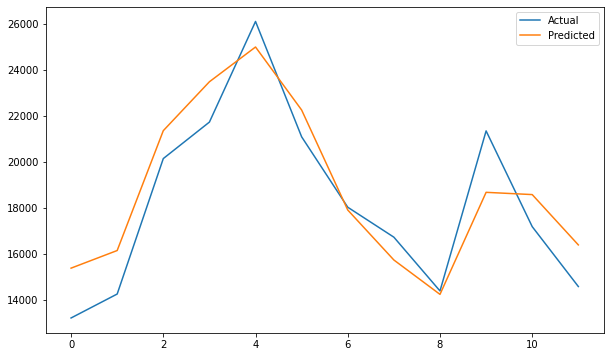

In [ ]:
dataframe.plot(figsize=(10, 6))

## **Summary**

In this tutorial, you discovered how to use the Facebook Prophet library for time series forecasting.

Specifically, you learned:

Prophet is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.
How to fit Prophet models and use them to make in-sample and out-of-sample forecasts.
How to evaluate a Prophet model on a hold-out dataset.